In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import math
from sklearn.metrics import r2_score

In [2]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [3]:
df = pd.read_csv("C:/Users/12137/Desktop/dsci560/processed_data/third_floor_sorted.csv", header=None)
df[0] = pd.to_datetime(df[0])

year = []
month = []
day = []
hour = []
number = []
weekday = []

for i in range(df[0].size):
    if df[0][i].hour < 8 or df[0][i].hour > 18:
        continue
    if df[0][i].year == 2019:
        year.append(1)
    else:
        year.append(2)
        
    month.append(df[0][i].month)
    day.append(df[0][i].day)
    hour.append(df[0][i].hour)
    
    number.append(df[1][i])
    
    weekday.append(df[0][i].weekday())

year = np.array(year)
month = np.array(month)
day = np.array(day)
hour = np.array(hour)
number = np.array(number)
weekday = np.array(weekday)

year = year[:, np.newaxis]
month = month[:, np.newaxis]
day = day[:, np.newaxis]
hour = hour[:, np.newaxis]
number = number[:, np.newaxis]
weekday = weekday[:, np.newaxis]

seq = np.concatenate((number, year, month, day, hour, weekday), axis=1)
# seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)

inp_dim = 6
out_dim = 1
mid_dim = 12
mid_layers = 2
batch_size = 12
mod_dir = '.'

data = seq
data_x = data[:-1, :]
data_y = data[+1:, 0]
assert data_x.shape[1] == inp_dim

train_size = int(len(data_x)-54)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim))
train_y = train_y.reshape((train_size, out_dim))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [4]:
net.load_state_dict(torch.load('E:/workspace/final_net/1800net_third.pth', map_location=lambda storage, loc: storage))
net = net.eval()

test_x = data_x.copy()
test_x[train_size:, 0] = 0
test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

pre = data_x.copy()
pre[train_size:, 0] = 0
pre = pre[:, np.newaxis, :]
pre = torch.tensor(pre, dtype=torch.float32, device=device)
'''simple way but no elegant'''
for i in range(1, train_size+1):
    test_y = net(test_x[:i])
    pre[i, 0, 0] = test_y[-1]
#     test_x[i, 0, 0] = test_y[-1]

# '''elegant way but slightly complicated'''
# eval_size = 1
# zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
# test_y, hc = net.output_y_hc(test_x[:1], (zero_ten, zero_ten))
# test_x[1, 0, 0] = test_y[-1]
# for i in range(len(data) - 2):
#     test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
#     test_x[i + 1, 0, 0] = test_y[-1]
# pred_y = test_x[1:, 0, 0]
# pred_y = pred_y.cpu().data.numpy()

# diff_y = pred_y[train_size:] - data_y[train_size:-1]
# l1_loss = np.mean(np.abs(diff_y))
# l2_loss = math.sqrt(np.mean(diff_y ** 2))
# print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

'''elegant way but slightly complicated'''
eval_size = 1
zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
test_x[train_size, 0, 0] = test_y[-1]
#     print(test_x[train_size])
for i in range(train_size, len(data) - 2):
    test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
    test_x[i + 1, 0, 0] = test_y[-1]
#         print(test_x[i+1])
pred_y = test_x[1:, 0, 0]
pred_y = pred_y.cpu().data.numpy()
# pred_y[:train_size] = pre.cpu().data.numpy()
pred_y[:train_size] = pre[1:train_size+1, 0, 0].cpu().data.numpy()

diff_y = pred_y[train_size:] - data_y[train_size:-1]
#     l1_loss = math.sqrt(np.mean(diff_y ** 2))
l1_loss = np.mean(np.abs((data_y[train_size:-1] - pred_y[train_size:]) / data_y[train_size:-1])) * 100
l2_loss = r2_score(data_y[train_size:-1],pred_y[train_size:])
print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

L1: 53.662    L2: 0.605


In [6]:
result = np.ceil(pred_y[train_size-1:])

In [159]:
result

array([158., 199., 247., 247., 232., 184., 171., 168., 167., 164., 164.,
       164., 163.,  70.,  41.,  30.,  31.,  32.,  33.,  34.,  30.,  33.,
        34.,  33.,  36.,  33.,  35.,  33.,  34.,  33.,  34.,  34.,  36.,
        32.,  34.,  38.,  19.,  -0., 237., 391., 467., 255., 660., 240.,
       454., 454., 454., 301., 202.,  73., 111., 322., 556., 539.],
      dtype=float32)

In [176]:
dateR = []
hourR = []
floorR = []

In [177]:
for x in range(train_size, len(year)-1):
#     dateR.append(str(year[x][0])+'-'+str(month[x][0])+'/'+str(day[x][0]))
    dateR.append(str(month[x][0])+'/'+str(day[x][0])+'/'+str(year[x][0]+2018))
    hourR.append(str(hour[x][0])+":00")
    floorR.append(0)

In [178]:
output = []
for x in range(len(dateR)):
    cur = []
    cur.append(dateR[x])
    cur.append(hourR[x])
    cur.append(floorR[x])
    cur.append(result[x])
    output.append(cur)

In [179]:
output

[['3/6/2020', '8:00', 0, 158.0],
 ['3/6/2020', '9:00', 0, 199.0],
 ['3/6/2020', '10:00', 0, 247.0],
 ['3/6/2020', '11:00', 0, 247.0],
 ['3/6/2020', '12:00', 0, 232.0],
 ['3/6/2020', '13:00', 0, 184.0],
 ['3/6/2020', '14:00', 0, 171.0],
 ['3/6/2020', '15:00', 0, 168.0],
 ['3/6/2020', '16:00', 0, 167.0],
 ['3/6/2020', '17:00', 0, 164.0],
 ['3/6/2020', '18:00', 0, 164.0],
 ['3/7/2020', '8:00', 0, 164.0],
 ['3/7/2020', '9:00', 0, 163.0],
 ['3/7/2020', '10:00', 0, 70.0],
 ['3/7/2020', '11:00', 0, 41.0],
 ['3/7/2020', '12:00', 0, 30.0],
 ['3/7/2020', '13:00', 0, 31.0],
 ['3/7/2020', '14:00', 0, 32.0],
 ['3/7/2020', '15:00', 0, 33.0],
 ['3/7/2020', '16:00', 0, 34.0],
 ['3/7/2020', '17:00', 0, 30.0],
 ['3/7/2020', '18:00', 0, 33.0],
 ['3/8/2020', '8:00', 0, 34.0],
 ['3/8/2020', '9:00', 0, 33.0],
 ['3/8/2020', '10:00', 0, 36.0],
 ['3/8/2020', '11:00', 0, 33.0],
 ['3/8/2020', '12:00', 0, 35.0],
 ['3/8/2020', '13:00', 0, 33.0],
 ['3/8/2020', '14:00', 0, 34.0],
 ['3/8/2020', '15:00', 0, 33.0],
 ['

In [180]:
np.savetxt("final_ground.csv", output, delimiter=",", fmt = '%s')

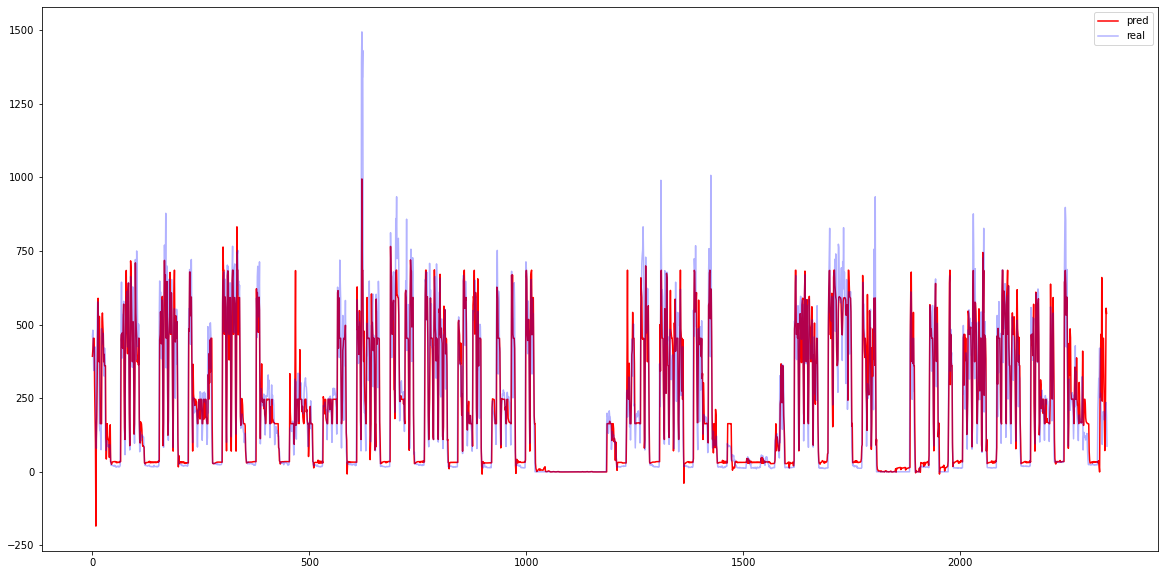

In [165]:
plt.figure(figsize=(20,10))
plt.plot(pred_y, 'r', label='pred')
plt.plot(data_y, 'b', label='real', alpha=0.3)
# plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
plt.legend(loc='best')
plt.savefig('lstm_reg.png')
plt.pause(4)

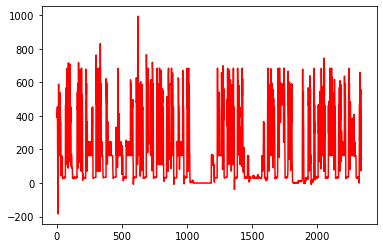

In [166]:
plt.plot(pred_y, 'r', label='pred')
plt.savefig('lstm_pre.png')

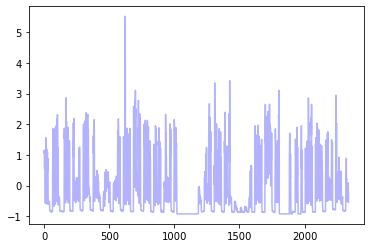

In [140]:
plt.plot(data_y, 'b', label='real', alpha=0.3)
plt.savefig('lstm_real.png')

In [8]:
xlables = ["8am","9am","10am","11am","12pm","13pm","14pm","15pm","16pm","17pm","18pm"]

In [139]:
data_y[train_size-1:-1]

array([-0.41898607, -0.34560918, -0.41466978, -0.39308834, -0.41898607,
       -0.45783265, -0.40172092, -0.4405675 , -0.36287433, -0.58732127,
       -0.72544247, -0.8160845 , -0.82040079, -0.8160845 , -0.8160845 ,
       -0.82040079, -0.82471708, -0.82040079, -0.82040079, -0.8160845 ,
       -0.82040079, -0.80745193, -0.8160845 , -0.82040079, -0.8160845 ,
       -0.82471708, -0.82040079, -0.82471708, -0.82040079, -0.82040079,
       -0.82040079, -0.82471708, -0.81176821, -0.01757135,  0.18961044,
        0.4442714 ,  0.39247595,  0.88884899,  0.15939643,  0.22414074,
        0.09033584, -0.14274368, -0.24201829, -0.52257696, -0.13842739,
       -0.04778536, -0.03915278, -0.10389709, -0.16432512, -0.11252967,
       -0.08231566, -0.02188763,  0.09033584, -0.12116224])

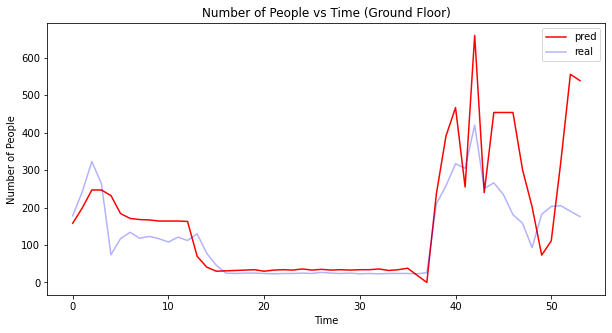

In [175]:
plt.figure(figsize=(10,5))
plt.plot(result, 'r', label='pred')
plt.plot(data_y[train_size-6:-6], 'b', label='real', alpha=0.3)
plt.legend(loc='best')
# plt.xticks(xlables)
plt.title("Number of People vs Time (Ground Floor)")
plt.xlabel("Time")
plt.ylabel("Number of People")
plt.savefig('pre_ground.png')
plt.pause(4)

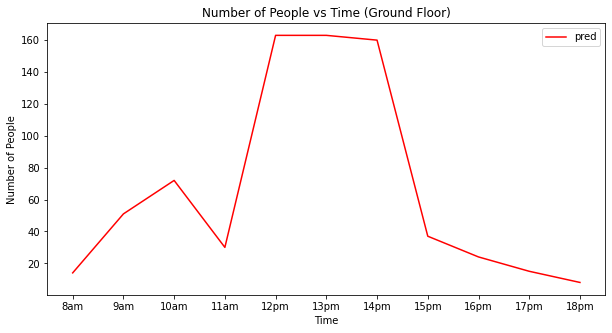

In [12]:
plt.figure(figsize=(10,5))
plt.plot(result[0:11], 'r', label='pred')
# plt.plot(data_y[train_size-1:-1], 'b', label='real', alpha=0.3)
plt.legend(loc='best')
x=np.linspace(0,10,11)
plt.xticks(x,xlables)
plt.title("Number of People vs Time (Ground Floor)")
plt.xlabel("Time")
plt.ylabel("Number of People")
plt.savefig('final_third1.png')
plt.pause(4)

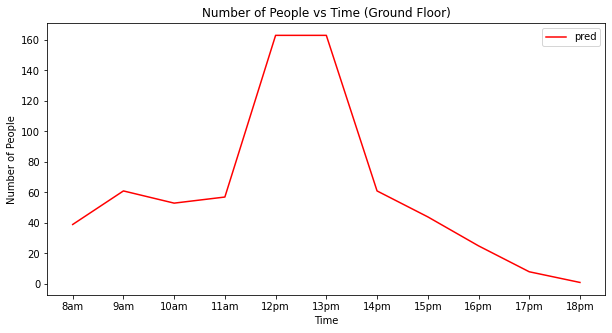

In [11]:
plt.figure(figsize=(10,5))
plt.plot(result[0+11+11:11+11+11], 'r', label='pred')
# plt.plot(data_y[train_size-1:-1], 'b', label='real', alpha=0.3)
plt.legend(loc='best')
x=np.linspace(0,10,11)
plt.xticks(x,xlables)
plt.title("Number of People vs Time (Ground Floor)")
plt.xlabel("Time")
plt.ylabel("Number of People")
plt.savefig('final_third3.png')
plt.pause(4)

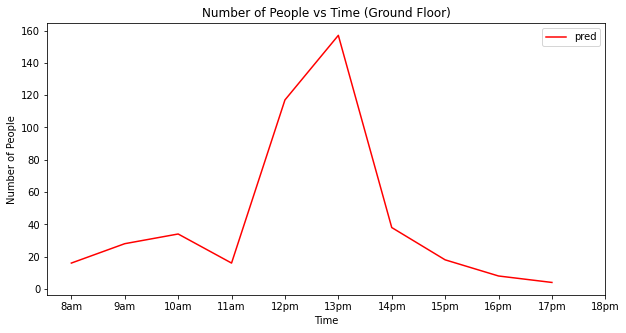

In [10]:
plt.figure(figsize=(10,5))
plt.plot(result[0+11+11+11+11:11+11+11+11+11], 'r', label='pred')
# plt.plot(data_y[train_size-1:-1], 'b', label='real', alpha=0.3)
plt.legend(loc='best')
x=np.linspace(0,10,11)
plt.xticks(x,xlables)
plt.title("Number of People vs Time (Ground Floor)")
plt.xlabel("Time")
plt.ylabel("Number of People")
plt.savefig('final_third4.png')
plt.pause(4)

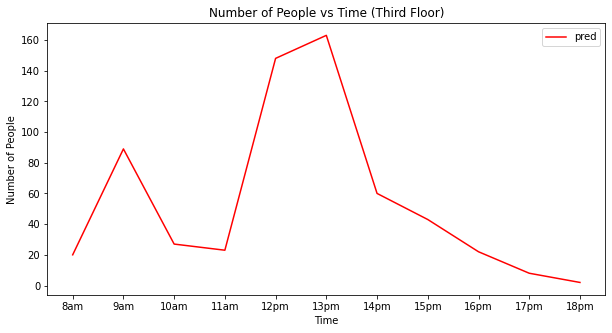

In [9]:
plt.figure(figsize=(10,5))
plt.plot(result[0+11:11+11], 'r', label='pred')
# plt.plot(data_y[train_size-1:-1], 'b', label='real', alpha=0.3)
plt.legend(loc='best')
x=np.linspace(0,10,11)
plt.xticks(x,xlables)
plt.title("Number of People vs Time (Third Floor)")
plt.xlabel("Time")
plt.ylabel("Number of People")
plt.savefig('final_third2.png')
plt.pause(4)